In [21]:
# !pip install --user scikit-image
# !pip install --upgrade python-bidi
# !pip install torchmetrics

In [22]:
import sys
sys.path.append("./EasyOCR")

In [23]:
from torch.utils.data import Dataset
from PIL import Image
import json
import os
import random
import numpy as np
import torch
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from torch.optim import AdamW
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn as nn
from pythainlp.tokenize import word_tokenize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device : {device}')

Device : cuda


In [24]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Dataset

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
import json
import torchvision.transforms as T

class EasyOCRDataset(Dataset):
    def __init__(self, data_root, img_height=128, img_width=600, gt_filename="gt.txt"):
        """
        data_root/
        ├── gt.txt          # lines: test/word_1.png\t<label>
        └── train/
            ├ word_1.png
            ├ word_2.png
            └ ...
        """
        self.data_root = data_root
        self.image_dir = os.path.join(data_root, "train")
        gt_path = os.path.join(data_root, gt_filename)

        # read gt.txt into a list of (relative_path, label)
        self.samples = []
        with open(gt_path, "r", encoding="utf-8") as f:
            for line in f:
                rel_path, label = line.strip().split("\t", 1)
                self.samples.append((rel_path, label))

        # transforms: grayscale → resize → tensor → normalize
        self.transform = T.Compose([
            T.Grayscale(num_output_channels=1),
            T.Resize((img_height, img_width)),
            T.ToTensor(),
            T.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rel_path, label = self.samples[idx]
        img_path = os.path.join(self.data_root, rel_path)

        # load & transform
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)  # [1, H, W]

        return image, label

In [26]:
import torch
from torch.utils.data import DataLoader, random_split, Subset
import random

# Load the dataset
dataset = EasyOCRDataset("./ThaiOCR-Synth")

# Set seed for reproducibility
seed = 22
batch_size = 32
generator = torch.Generator().manual_seed(seed)

# Shuffle indices manually
indices = list(range(len(dataset)))
random.Random(seed).shuffle(indices)

# Take only the first 5000 shuffled indices
limited_indices = indices[:5000]

# Create a shuffled subset
shuffled_dataset = Subset(dataset, limited_indices)

# Split lengths
total_len = len(limited_indices)
train_len = int(0.8 * total_len)
valid_len = int(0.1 * total_len)
test_len  = total_len - train_len - valid_len

# Split the dataset
train_set, valid_set, test_set = random_split(shuffled_dataset, [train_len, valid_len, test_len], generator=generator)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

In [27]:
# simple validation loop
def validate(model, loader, converter, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            logits = model(imgs)           # raw CTC logits
            preds  = converter.decode(logits.softmax(-1))
            for p,t in zip(preds, labels):
                if p == t: correct += 1
                total  += 1
    return correct/total

In [28]:
print(f'Len Training data : {train_len}')

Len Training data : 4000


In [29]:
print(f'Len Valid data : {valid_len}')

Len Valid data : 500


In [30]:
print(f'Len Test data : {test_len}')

Len Test data : 500


In [31]:
for images, labels in train_loader:
    print(images.shape)
    print(labels)
    break

torch.Size([32, 1, 128, 600])
('Information', 'ส่วนผสมหลักคือ', 'ปีที่มหัศจรรย์', 'ยืมมาจากภาษาซีพลัสพลัส', 'นิสิตเก่าคณะสถาปัตยกรรมศาสตร์', 'โป้วอั้งเสาะ', 'วันสำคัญทางศาสนา', 'เช้าตรู่วันที่', 'และสองชั่วโมงหลังจากการประกาศยึดอำนาจ', 'รัฐบาลทหารได้แจ้ง', 'มีการผลิตและปริมาณสำรองน้ำมันน้อยและต้องนำเข้าเป็นส่วนใหญ่เพื่อการบริโภค', 'กลุ่มที่ห้า', 'ฝรั่งเศสทางตอนเหนือมีอาคารและสิ่งก่อสร้างจำนวนมากที่เป็นแบบกอทิก', 'เป็นพื้นที่ที่สูงกว่าระดับน้ำทะเลโดยเฉลี่ย', 'unconnected', 'เป็นพระพุทธเจ้าที่อวตารมาจากอาทิพุทธะมาเกิดในโลกมนุษย์และบำเพ็ญเพียรในฐานะพระโพธิสัตว์จนตรัสรู้เป็นพระพุทธเจ้า', 'ดำรงตำแหน่งนายกสภามหาวิทยาลัยเทคโนโลยีราชมงคลทั้ง', 'และผู้บัญชาการทหารบก', 'ถึงแม้ว่ามักจะใช้กับข้อมูลสนับสนุนมากกว่าข้อมูลในส่วนสำคัญก็ตาม', 'หลังจากการสถาปนาราชบัณฑิตยสถานสเปนขึ้นในคริสต์ศตวรรษที่', 'ประเพณีสงกรานต์', 'ตามข้อมูลจากปี', 'แม้ว่าพระราชอำนาจดังกล่าวจะมิได้บัญญัติเป็นลายลักษณ์อักษรไว้ในรัฐธรรมนูญฉบับใดก็ตาม', 'ผู้สืบทอดราชบัลลังก์', 'ในเดือนกุมภาพันธ์', 'กำหนดให้มีสองสภา', 'และต้องผ่านเกณฑ์

In [32]:
labels

('Information',
 'ส่วนผสมหลักคือ',
 'ปีที่มหัศจรรย์',
 'ยืมมาจากภาษาซีพลัสพลัส',
 'นิสิตเก่าคณะสถาปัตยกรรมศาสตร์',
 'โป้วอั้งเสาะ',
 'วันสำคัญทางศาสนา',
 'เช้าตรู่วันที่',
 'และสองชั่วโมงหลังจากการประกาศยึดอำนาจ',
 'รัฐบาลทหารได้แจ้ง',
 'มีการผลิตและปริมาณสำรองน้ำมันน้อยและต้องนำเข้าเป็นส่วนใหญ่เพื่อการบริโภค',
 'กลุ่มที่ห้า',
 'ฝรั่งเศสทางตอนเหนือมีอาคารและสิ่งก่อสร้างจำนวนมากที่เป็นแบบกอทิก',
 'เป็นพื้นที่ที่สูงกว่าระดับน้ำทะเลโดยเฉลี่ย',
 'unconnected',
 'เป็นพระพุทธเจ้าที่อวตารมาจากอาทิพุทธะมาเกิดในโลกมนุษย์และบำเพ็ญเพียรในฐานะพระโพธิสัตว์จนตรัสรู้เป็นพระพุทธเจ้า',
 'ดำรงตำแหน่งนายกสภามหาวิทยาลัยเทคโนโลยีราชมงคลทั้ง',
 'และผู้บัญชาการทหารบก',
 'ถึงแม้ว่ามักจะใช้กับข้อมูลสนับสนุนมากกว่าข้อมูลในส่วนสำคัญก็ตาม',
 'หลังจากการสถาปนาราชบัณฑิตยสถานสเปนขึ้นในคริสต์ศตวรรษที่',
 'ประเพณีสงกรานต์',
 'ตามข้อมูลจากปี',
 'แม้ว่าพระราชอำนาจดังกล่าวจะมิได้บัญญัติเป็นลายลักษณ์อักษรไว้ในรัฐธรรมนูญฉบับใดก็ตาม',
 'ผู้สืบทอดราชบัลลังก์',
 'ในเดือนกุมภาพันธ์',
 'กำหนดให้มีสองสภา',
 'และต้องผ่านเกณฑ์การต

Information
ส่วนผสมหลักคือ
ปีที่มหัศจรรย์
ยืมมาจากภาษาซีพลัสพลัส
นิสิตเก่าคณะสถาปัตยกรรมศาสตร์
โป้วอั้งเสาะ
วันสำคัญทางศาสนา
เช้าตรู่วันที่


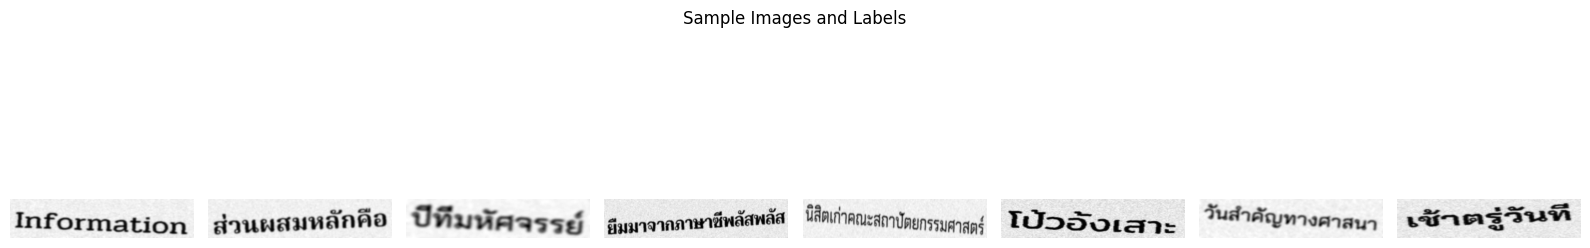

In [33]:
# Pick a few samples to display
num_to_display = 8
images_to_show = images[:num_to_display]
labels_to_show = labels[:num_to_display]

# Denormalize images (from [-1, 1] back to [0, 1])
images_to_show = images_to_show * 0.5 + 0.5  # Because normalized with mean=0.5, std=0.5

# Plot
plt.figure(figsize=(16, 4))
for i in range(num_to_display):
    img = images_to_show[i].squeeze(0).cpu().numpy()  # shape: [32, 160]
    print(labels_to_show[i][:30])

    plt.subplot(1, num_to_display, i + 1)
    plt.imshow(img, cmap='gray')
    #plt.title(f"{labels_to_show[i][:30]}...", fontsize=8)  # Truncate long text
    plt.axis('off')

plt.suptitle("Sample Images and Labels", fontsize=12)
plt.tight_layout()
plt.show()

# Model

In [34]:
# import torch.nn as nn
# from EasyOCR.easyocr.easyocr import Reader

# # Step 1: Initialize Reader for Thai
# reader = Reader(['th'], gpu=True)
# character_set = reader.character  # this is the character set used by the model

# # === Step 1: Prepare Model Config ===
# lang = 'th_custom'
# # recog_network = 'generation1' # Or another network architecture
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [35]:
# import torch
# from torchvision import transforms
# from PIL import Image, ImageEnhance
# from collections import OrderedDict
# import importlib
# import numpy as np
# import torch.nn.functional as F

# from EasyOCR.easyocr.utils import CTCLabelConverter
# from EasyOCR.easyocr.config import recognition_models

# # === Step 1: Prepare Model Config ===
# lang = 'th'
# recog_network = 'generation1'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model_config = recognition_models['gen1']['thai_g1']

# # character = model_config['characters']
# character = character_set
# model_path = f'./pretrained/{model_config["filename"]}'

# # === Step 2: Setup Converter & Params ===
# converter = CTCLabelConverter(character)
# num_class = len(converter.character)
# ignore_idx = []

# network_params = {
#     'input_channel': 1,
#     'output_channel': 512,
#     'hidden_size': 512
# }

# # === Step 3: Load Model with Strict Check ===
# model_pkg = importlib.import_module("easyocr.model.model")
# model = model_pkg.Model(num_class=num_class, **network_params)

# state_dict = torch.load(model_path, map_location=device)
# new_state_dict = OrderedDict((k[7:], v) if k.startswith("module.") else (k, v) for k, v in state_dict.items())

# load_result = model.load_state_dict(new_state_dict, strict=False)
# if load_result.missing_keys or load_result.unexpected_keys:
#     print("⚠️ Weight loading issues:")
#     if load_result.missing_keys:
#         print("Missing keys:", load_result.missing_keys)
#     if load_result.unexpected_keys:
#         print("Unexpected keys:", load_result.unexpected_keys)
#     raise ValueError("Model weights mismatch. Aborting due to strict=True policy.")
    

# model.load_state_dict(new_state_dict, strict=True)
# model = model.to(device)

In [36]:
import torch
from torchvision import transforms
from PIL import Image, ImageEnhance
from collections import OrderedDict
import importlib
import numpy as np
import torch.nn.functional as F

from easyocr.utils import CTCLabelConverter
from easyocr.config import recognition_models

In [37]:
# === Step 1: Prepare Model Config ===
lang = 'th'
recog_network = 'generation1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_config = recognition_models['gen1']['thai_g1']

# Define your custom character set
thai_chars = 'กขฃคฅฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรลวศษสหฬอฮฤฦฯะัาำิีึืุูเแโใไๅๆ็่้๊๋์ํฺ'
english_chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
numeric_chars = '0123456789'
special_chars = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '

base_character_set = thai_chars + english_chars + numeric_chars + special_chars

# read gt.txt into a list of labels
all_labels = []
gt_path = "./ThaiOCR-Synth/gt.txt"
with open(gt_path, "r", encoding="utf-8") as f:
    for line in f:
        rel_path, label = line.strip().split("\t", 1)
        all_labels.append(label)

# Create a set of all unique characters present in your text data
all_chars_from_text = set("".join(all_labels))
# Convert your base character set to a set for easy comparison
existing_chars_set = set(base_character_set)
newly_found_chars = all_chars_from_text - existing_chars_set

character_set = base_character_set

if newly_found_chars:
    # Sort the new characters for consistent ordering
    new_chars_to_add = "".join(sorted(list(newly_found_chars)))
    
    print(f"✅ Found {len(new_chars_to_add)} new character(s) missing from your set:")
    print(f"   New Characters: {new_chars_to_add}")
    
    # Append the new characters to your base set
    character_set += new_chars_to_add
    
    print(f"\nUpdated character set size: {len(character_set)}")

else:
    print("✅ No new characters were found.")
    print("   Your character set is already complete for this data.")

print("-" * 50)

✅ No new characters were found.
   Your character set is already complete for this data.
--------------------------------------------------


In [38]:
# Use the custom character set
character = character_set
model_path = f'./pretrained/{model_config["filename"]}'

# === Step 2: Setup Converter & Params ===
converter = CTCLabelConverter(character)
num_class = len(converter.character)
# The ignore_idx is handled by the converter, no need to set it manually

network_params = {
    'input_channel': 1,
    'output_channel': 512,
    'hidden_size': 512,
    'num_class': num_class  # Pass num_class to the model constructor
}

# === Step 3: Load Model with Strict Check ===
model_pkg = importlib.import_module("easyocr.model.model")
# Ensure the model architecture matches what you're loading
# If you are using a custom model, you might need to adjust this.
# For standard models, the network_params should be sufficient.
model = model_pkg.Model(**network_params)

# It's generally better to load the pretrained model first and then
# adapt the final classification layer for your custom number of classes.

# Load the pretrained weights
state_dict = torch.load(model_path, map_location=device)
# First, create the new state_dict by stripping the 'module.' prefix
new_state_dict = OrderedDict((k[7:], v) if k.startswith("module.") else (k, v) for k, v in state_dict.items())

# **DEBUG**: Print all the keys in the new state_dict to see what's available
print("Keys available in the model's state_dict:")
print(list(new_state_dict.keys()))
print("-" * 50)


# Now, access the cleaned key 'Prediction.weight' to get the size
# Also, add a check to ensure the key exists before accessing it
prediction_weight_key = 'Prediction.weight'
if prediction_weight_key not in new_state_dict:
    raise KeyError(f"The key '{prediction_weight_key}' was not found in the model state_dict. "
                   f"Please check the printed keys above to find the correct key for the final prediction layer's weights.")

pretrained_num_class = new_state_dict[prediction_weight_key].shape[0]

# If the number of classes is different, re-initialize the final layer.
if num_class != pretrained_num_class:
    print(f"⚠️ Number of classes differs. Pretrained model has {pretrained_num_class}, your model has {num_class}.")
    print("Re-initializing the final prediction layer.")
    # Remove the old prediction layer weights so they aren't loaded
    del new_state_dict['Prediction.weight']
    del new_state_dict['Prediction.bias']

    # Load all other weights with strict=False
    load_result = model.load_state_dict(new_state_dict, strict=False)
    print("Missing keys:", load_result.missing_keys) # Should be ['Prediction.weight', 'Prediction.bias']
    print("Unexpected keys:", load_result.unexpected_keys)

else:
    # If number of classes is the same, load everything strictly
    model.load_state_dict(new_state_dict, strict=True)

model = model.to(device)

print("\n✅ Model setup complete with the custom character set.")
print(f"Character set contains {len(character)} characters.")

C:\Users\Admin\AppData\Local\Temp\ipykernel_5440\2157011951.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Keys available in the model's state_dict:
['FeatureExtraction.ConvNet.conv0_1.weight', 'FeatureExtraction.ConvNet.bn0_1.weight', 'FeatureExtraction.ConvNet.bn0_1.bias', 'FeatureExtraction.ConvNet.bn0_1.running_mean', 'FeatureExtraction.ConvNet.bn0_1.running_var', 'FeatureExtraction.ConvNet.bn0_1.num_batches_tracked', 'FeatureExtraction.ConvNet.conv0_2.weight', 'FeatureExtraction.ConvNet.bn0_2.weight', 'FeatureExtraction.ConvNet.bn0_2.bias', 'FeatureExtraction.ConvNet.bn0_2.running_mean', 'FeatureExtraction.ConvNet.bn0_2.running_var', 'FeatureExtraction.ConvNet.bn0_2.num_batches_tracked', 'FeatureExtraction.ConvNet.layer1.0.conv1.weight', 'FeatureExtraction.ConvNet.layer1.0.bn1.weight', 'FeatureExtraction.ConvNet.layer1.0.bn1.bias', 'FeatureExtraction.ConvNet.layer1.0.bn1.running_mean', 'FeatureExtraction.ConvNet.layer1.0.bn1.running_var', 'FeatureExtraction.ConvNet.layer1.0.bn1.num_batches_tracked', 'FeatureExtraction.ConvNet.layer1.0.conv2.weight', 'FeatureExtraction.ConvNet.layer1.0.

In [44]:
len(character)

167

In [23]:
# The path where you want to save the file
char_file_path = './models/synth/custom_char.txt'

try:
    # Use 'utf-8' encoding, which is crucial for handling Thai characters
    with open(char_file_path, 'w', encoding='utf-8') as f:
        f.write(character_set)
    
    print(f"✅ Character set successfully saved to: {char_file_path}")
    print(f"\tTotal characters saved: {len(character_set)}")

except Exception as e:
    print(f"⚠️ An error occurred: {e}")

✅ Character set successfully saved to: ./models/synth/custom_char.txt
	Total characters saved: 167


In [19]:
for param in model.FeatureExtraction.parameters():
    param.requires_grad = False
for param in model.FeatureExtraction.ConvNet.layer4.parameters():
    param.requires_grad = True

In [20]:
frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🔒 Frozen parameters: {frozen_params:,}")
print(f"🟢 Trainable parameters: {trainable_params:,}")
print(f"📊 Total parameters: {frozen_params + trainable_params:,}")

🔒 Frozen parameters: 30,101,984
🟢 Trainable parameters: 23,702,696
📊 Total parameters: 53,804,680


In [21]:
import torch.nn as nn
import torch.optim as optim

criterion = torch.nn.CTCLoss(zero_infinity=True).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Train

In [22]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics.text import CharErrorRate, WordErrorRate

# === Assume these are already defined ===
# model, optimizer, criterion, converter, train_loader, valid_loader, device

def clean_text(text):
    return text.strip().replace(" ", "").lower()

# === Training Setup ===
num_epochs = 100

train_losses = []
val_losses = []
cer_list = []
wer_list = []
best_cer = float("inf")

# Folder setup
metrics_dir = "metrics/synth"
model_dir = "models/synth"
os.makedirs(metrics_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# Initialize torchmetrics metrics
cer_metric = CharErrorRate()
wer_metric = WordErrorRate()

for epoch in range(1, num_epochs + 1):
    # === Training ===
    model.train()
    for images, labels in train_loader:
        images = images.to(device)

        targets, lengths = converter.encode(labels)
        targets = targets.to(device)
        lengths = lengths.to(device)

        preds = model(images, text=targets).log_softmax(2)
        batch_size = images.size(0)
        preds_size = torch.IntTensor([preds.size(1)] * batch_size).to(device)
        preds = preds.permute(1, 0, 2)

        loss = criterion(preds, targets, preds_size, lengths)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}")
    train_losses.append(loss.item())

    # === Validation ===
    model.eval()
    val_loss = 0
    preds_str_all = []
    labels_all = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)

            targets, lengths = converter.encode(labels)
            targets = targets.to(device)
            lengths = lengths.to(device)

            preds = model(images, text=targets).log_softmax(2)
            batch_size = images.size(0)
            preds_size = torch.IntTensor([preds.size(1)] * batch_size).to(device)
            preds = preds.permute(1, 0, 2)

            loss = criterion(preds, targets, preds_size, lengths)
            val_loss += loss.item()

            _, preds_index = preds.max(2)  # [B, T]
            preds_index = preds_index.transpose(1, 0).contiguous().view(-1).cpu().numpy()
            preds_size_cpu = preds_size.cpu().numpy()
            preds_str = converter.decode_greedy(preds_index, preds_size_cpu)

            preds_str_all.extend(preds_str)
            labels_all.extend(labels)

    # === Filter out empty preds ===
    preds_filtered = []
    labels_filtered = []
    empty_count = 0

    for p, l in zip(preds_str_all, labels_all):
        if p != "":
            preds_filtered.append(p)
            labels_filtered.append(l)
        else:
            empty_count += 1

    print(f"⚠️ Skipped {empty_count} empty predictions this epoch")

    # === Compute Metrics ===
    if preds_filtered:
        cer = cer_metric(preds_filtered, labels_filtered).item()
        wer = wer_metric(preds_filtered, labels_filtered).item()
    else:
        cer = 1.0
        wer = 1.0
        print("⚠️ No valid predictions to compute metrics for this epoch.")

    avg_val_loss = val_loss / len(valid_loader)

    val_losses.append(avg_val_loss)
    cer_list.append(cer)
    wer_list.append(wer)

    print(f"Validation Loss = {avg_val_loss:.4f} | CER = {cer:.4f} | WER = {wer:.4f}")

    # === Save best model based on CER ===
    if cer < best_cer:
        best_cer = cer
        best_model_path = os.path.join(model_dir, "thai.pth")
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ New best model saved to: {best_model_path} (CER: {cer:.4f})")

    # === Debug: Visual Check on Predictions (every 5 epochs) ===
    if epoch % 5 == 0:
        checkpoint_path = os.path.join(model_dir, f"checkpoint_{epoch}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ Checkpoint {epoch} saved to: {checkpoint_path}")

        print(f"\n🔍 Debug Sample Predictions (Epoch {epoch}, First 10):")
        for i in range(min(10, len(preds_filtered))):
            print(f"GT   : {labels_filtered[i]!r}")
            print(f"PRED : {preds_filtered[i]!r}")
            print("---")

# === Plotting and Saving Metrics ===
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)

# Plot CER
plt.subplot(1, 3, 2)
plt.plot(epochs, cer_list, label="CER", marker='o', color='orange')
plt.xlabel("Epoch")
plt.ylabel("CER")
plt.title("Character Error Rate (CER)")
plt.legend()
plt.grid(True)

# Plot WER
plt.subplot(1, 3, 3)
plt.plot(epochs, wer_list, label="WER", marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("WER")
plt.title("Word Error Rate (WER)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plot_path = os.path.join(metrics_dir, "training_metrics.png")
plt.savefig(plot_path)
plt.show()
print(f"📊 Metrics plot saved to: {plot_path}")

c:\Users\Admin\anaconda3\envs\dsai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Admin\anaconda3\envs\dsai\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Epoch 1: Train Loss = 3.9079
⚠️ Skipped 470 empty predictions this epoch
Validation Loss = 3.8620 | CER = 0.9829 | WER = 1.0000
✅ New best model saved to: models/synth\thai.pth (CER: 0.9829)
Epoch 2: Train Loss = 3.1409
⚠️ Skipped 251 empty predictions this epoch
Validation Loss = 3.0779 | CER = 0.9345 | WER = 1.0000
✅ New best model saved to: models/synth\thai.pth (CER: 0.9345)
Epoch 3: Train Loss = 0.7800
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.7760 | CER = 0.2546 | WER = 0.8520
✅ New best model saved to: models/synth\thai.pth (CER: 0.2546)
Epoch 4: Train Loss = 0.6896
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.4680 | CER = 0.1876 | WER = 0.6580
✅ New best model saved to: models/synth\thai.pth (CER: 0.1876)
Epoch 5: Train Loss = 0.3063
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.3637 | CER = 0.1625 | WER = 0.5600
✅ New best model saved to: models/synth\thai.pth (CER: 0.1625)
✅ Checkpoint 5 saved to: models/synth\checkpoint_5.

KeyboardInterrupt: 